In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

width = 12
height = 7
plt.rcParams["figure.figsize"] = (width, height)


from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import tflscripts
import json
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from statistics import mode

In [2]:
dataset = 'scott-final-iter3'
device = '128.237.227.76'

dataset_path = '../../datasets/' + dataset + '/'
configuration = tflscripts.read_configuration()

In [3]:
df = pd.DataFrame.from_csv(dataset_path + device + '_MICROPHONE_sst.csv')
df.index = pd.to_datetime(df.index).round('100ms')

activities = pd.DataFrame.from_csv(dataset_path + 'activities.csv')
activities.index = pd.to_datetime(activities.index).round('100ms')
activities.sort_index(inplace=True)
labels = pd.DataFrame.from_csv(dataset_path + 'activity_labels.csv')

df = df.loc[df.index.isin(activities.index)]
activities = activities.loc[activities.index.isin(df.index)]

df = df[~df.index.duplicated(keep='first')]
activities = activities[~activities.index.duplicated(keep='first')]

df = pd.concat([df, activities], axis=1)

In [4]:
labels['since'] = [df.loc[df.id == i].index.min() for i in labels.index]
labels['until'] = [df.loc[df.id == i].index.max() for i in labels.index]

move_window(114, by=0.1, window_length=activity_length)


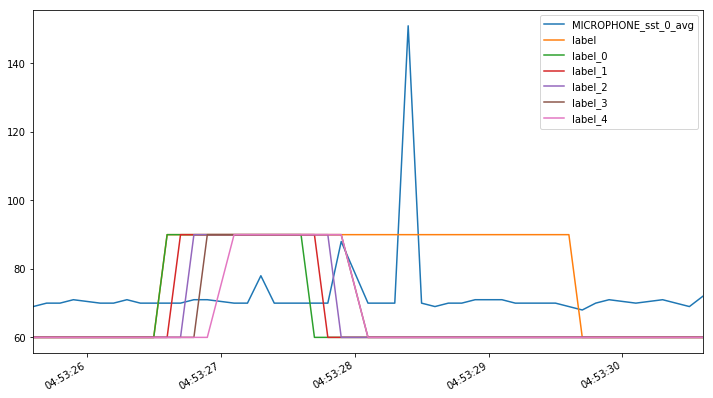

move_window(115, by=0.1, window_length=activity_length)


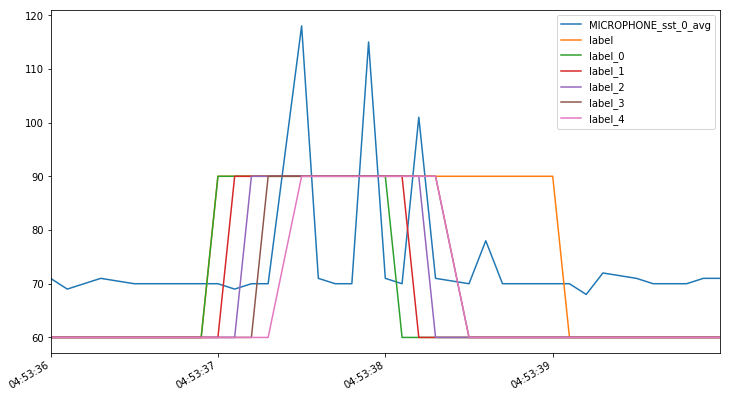

move_window(116, by=0.1, window_length=activity_length)


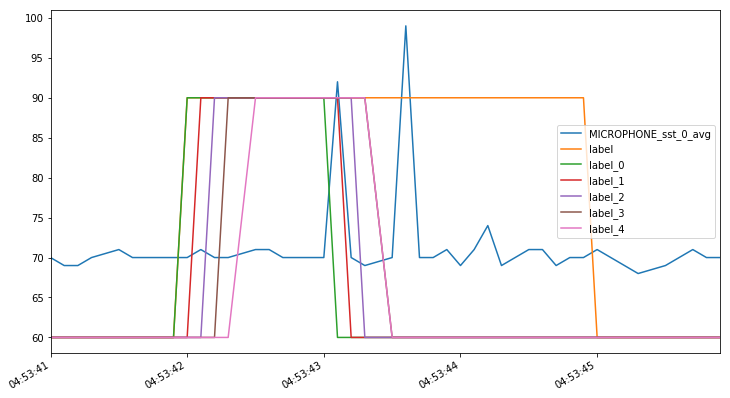

move_window(117, by=0.1, window_length=activity_length)


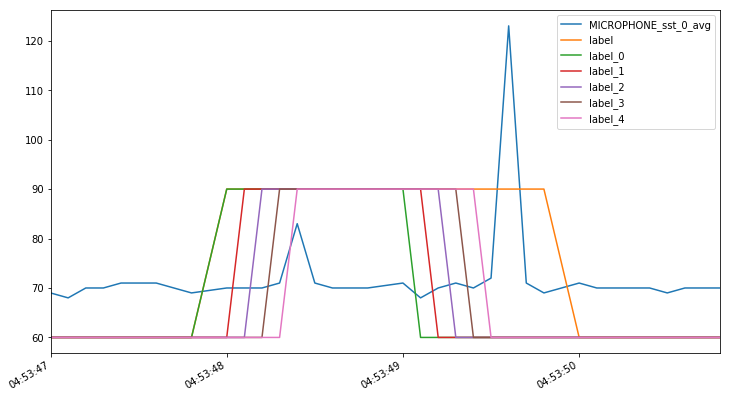

move_window(118, by=0.1, window_length=activity_length)


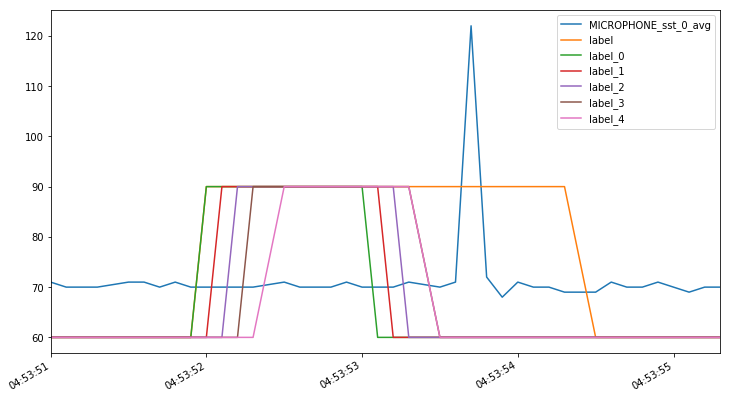

move_window(119, by=0.1, window_length=activity_length)


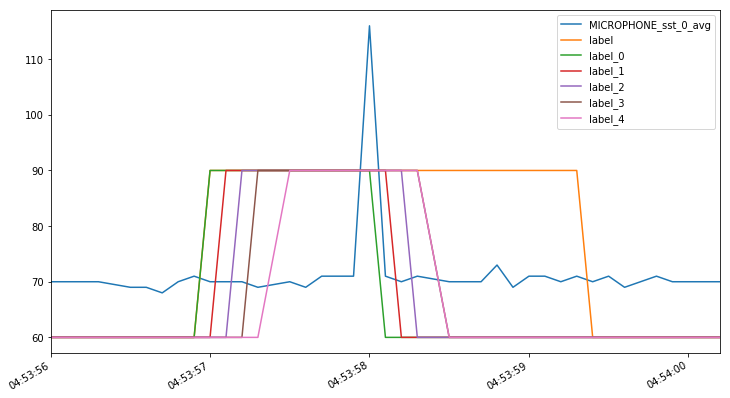

move_window(120, by=0.1, window_length=activity_length)


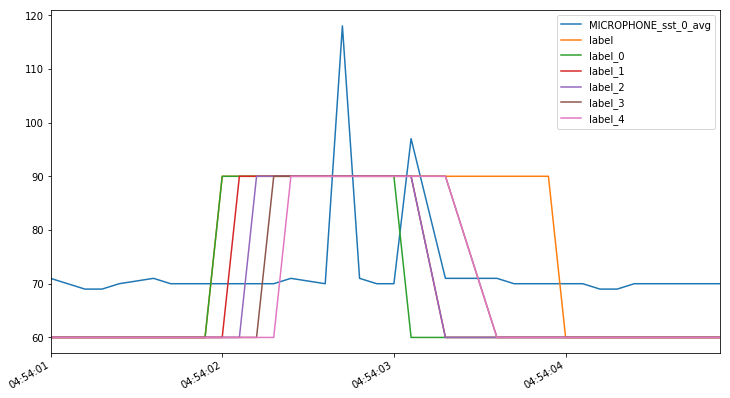

move_window(121, by=0.1, window_length=activity_length)


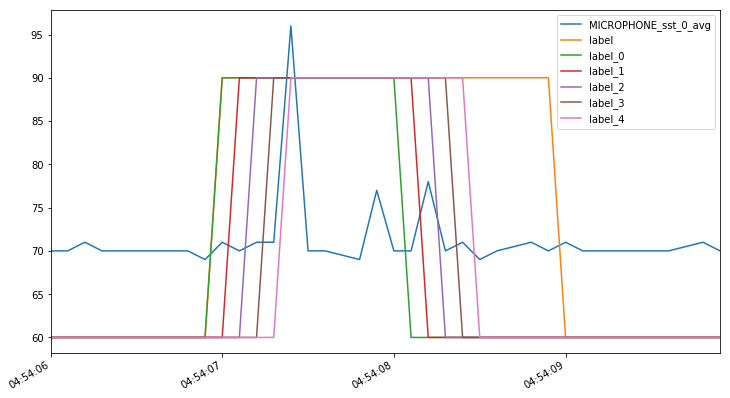

move_window(122, by=0.1, window_length=activity_length)


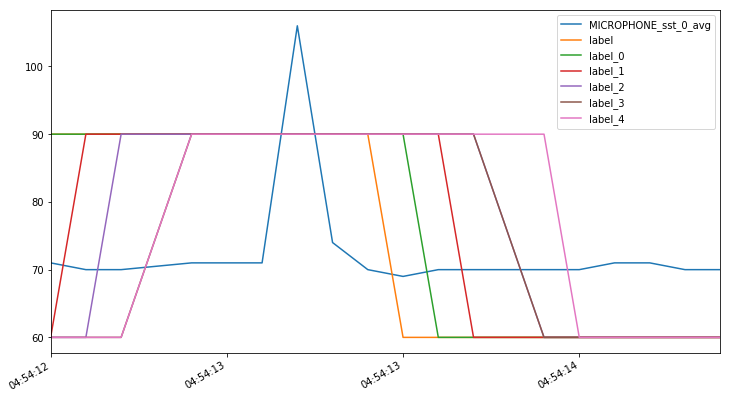

move_window(123, by=0.1, window_length=activity_length)


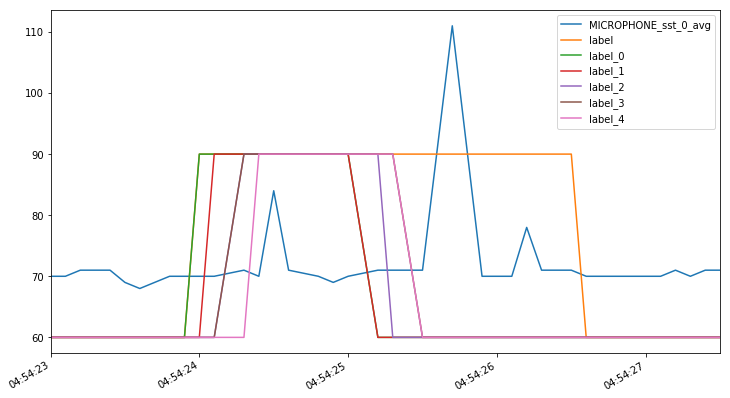

move_window(124, by=0.1, window_length=activity_length)


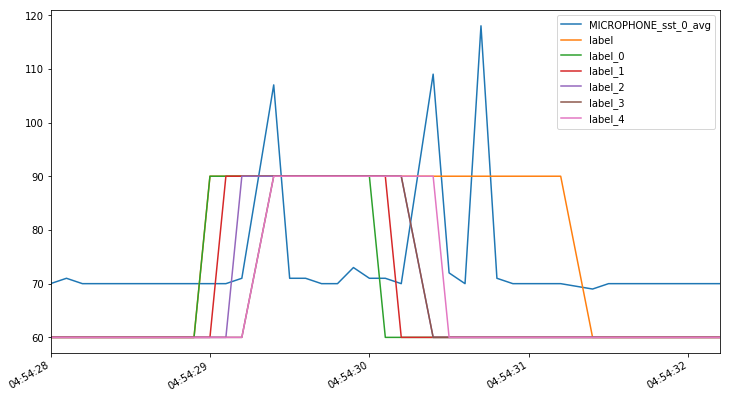

move_window(125, by=0.1, window_length=activity_length)


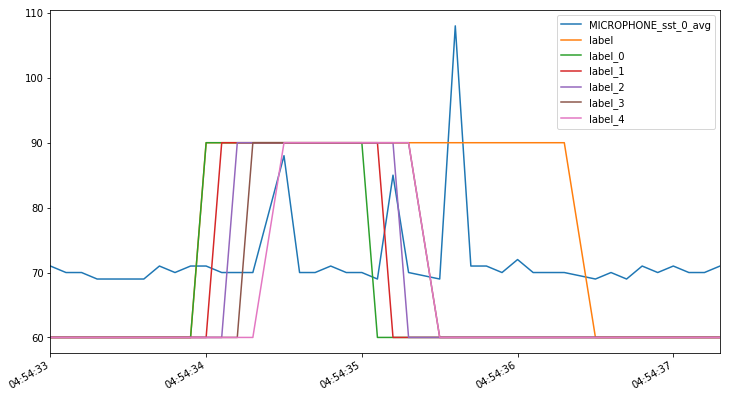

move_window(126, by=0.1, window_length=activity_length)


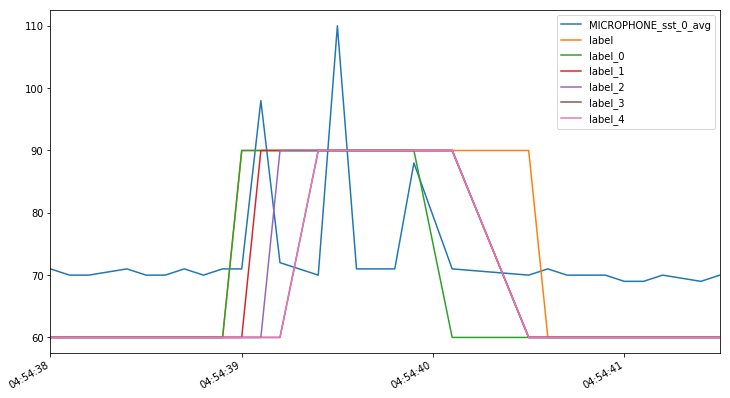

move_window(127, by=0.1, window_length=activity_length)


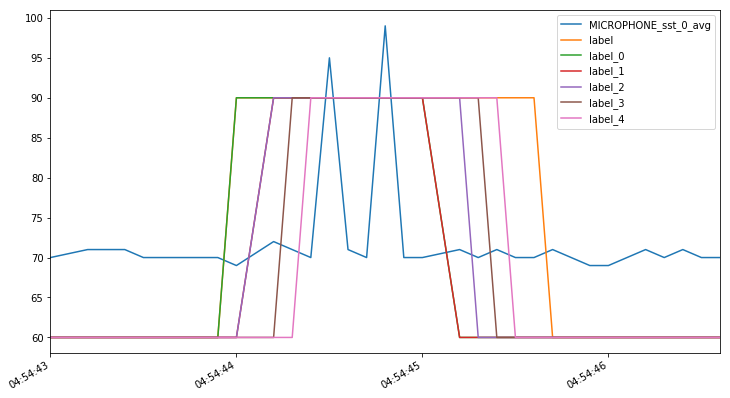

move_window(128, by=0.1, window_length=activity_length)


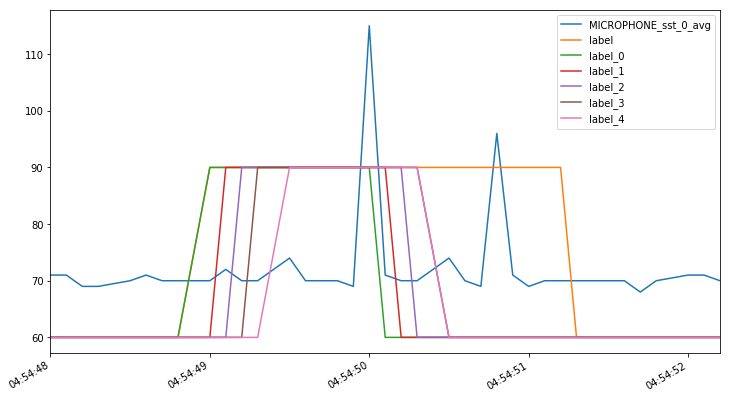

move_window(129, by=0.1, window_length=activity_length)


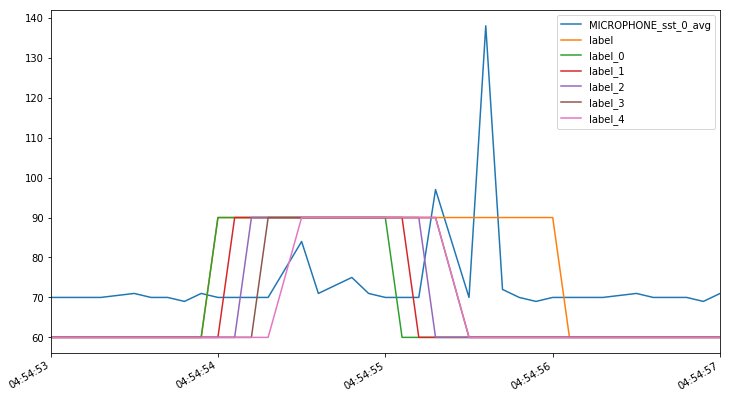

move_window(130, by=0.1, window_length=activity_length)


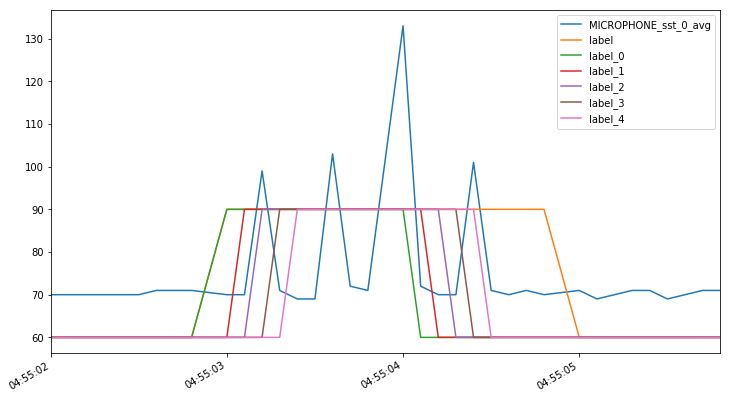

move_window(131, by=0.1, window_length=activity_length)


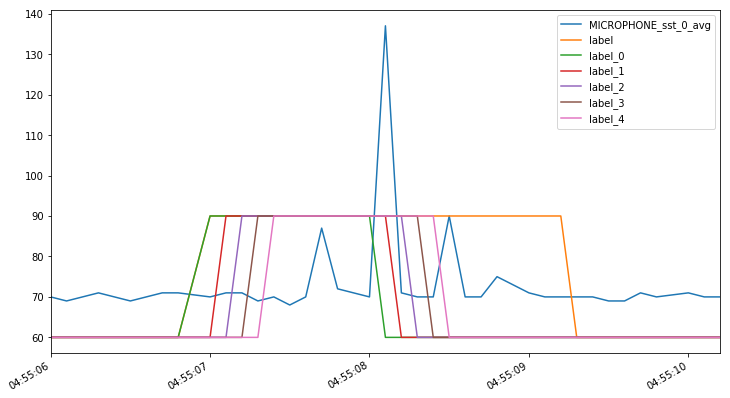

move_window(132, by=0.1, window_length=activity_length)


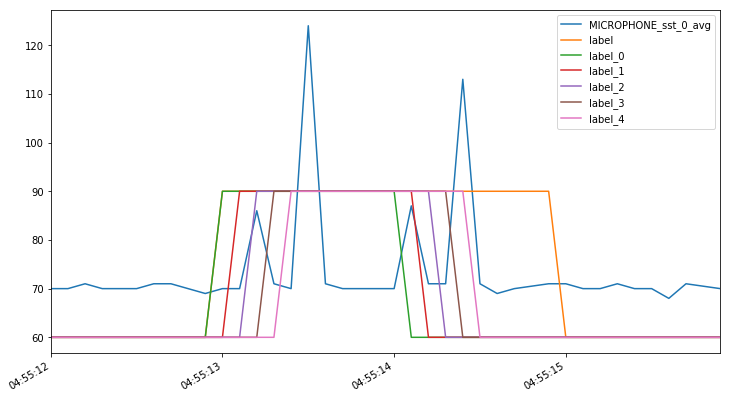

move_window(133, by=0.1, window_length=activity_length)


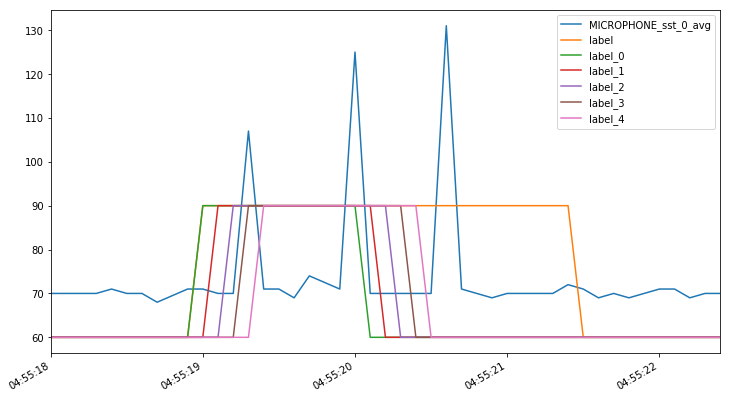

move_window(134, by=0.1, window_length=activity_length)


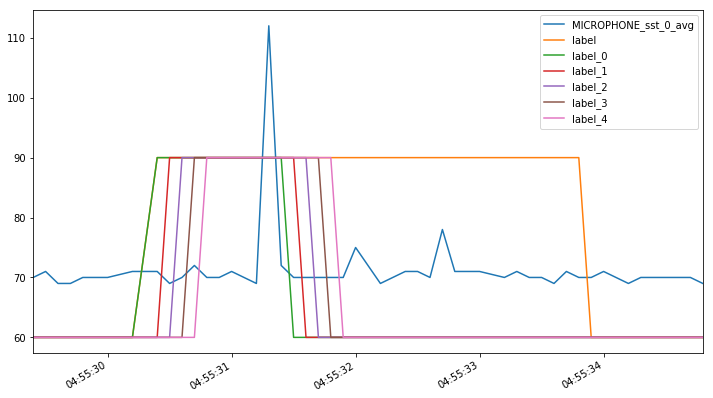

move_window(135, by=0.1, window_length=activity_length)


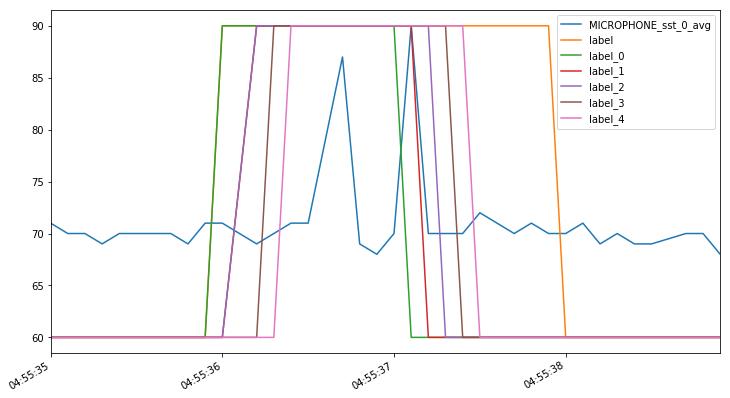

move_window(244, by=0.1, window_length=activity_length)


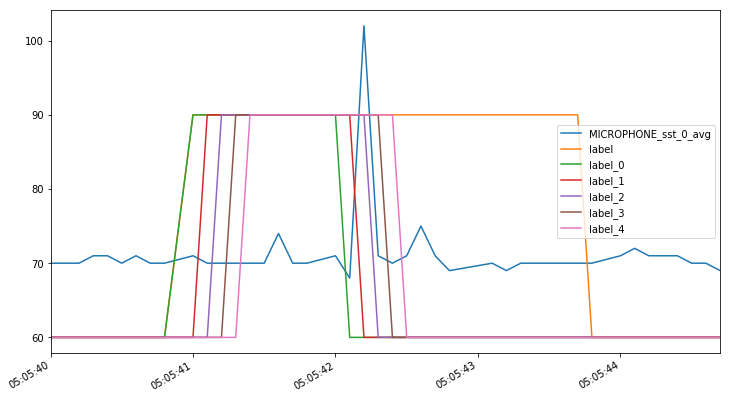

move_window(245, by=0.1, window_length=activity_length)


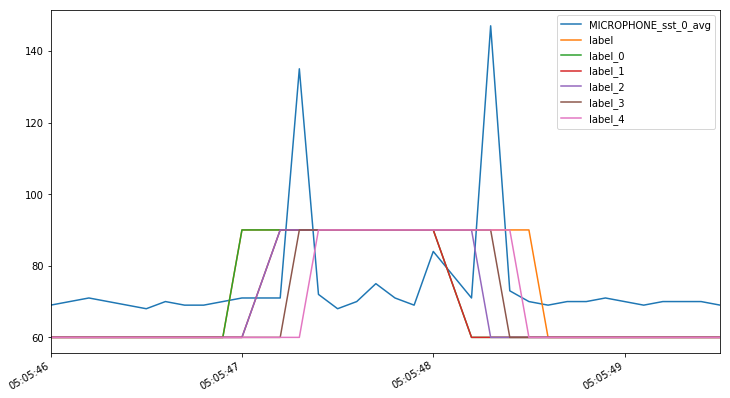

move_window(246, by=0.1, window_length=activity_length)


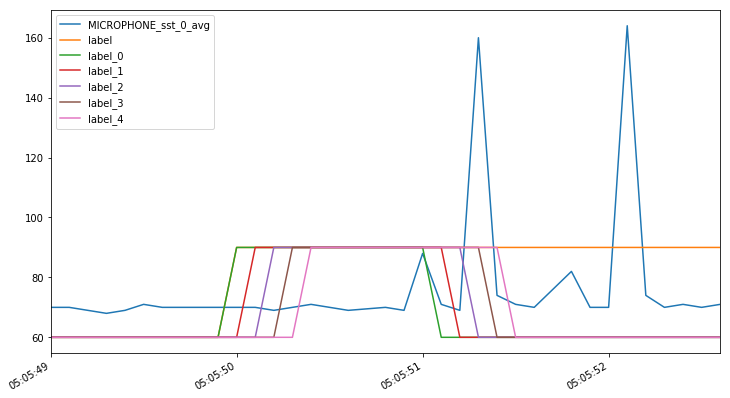

move_window(247, by=0.1, window_length=activity_length)


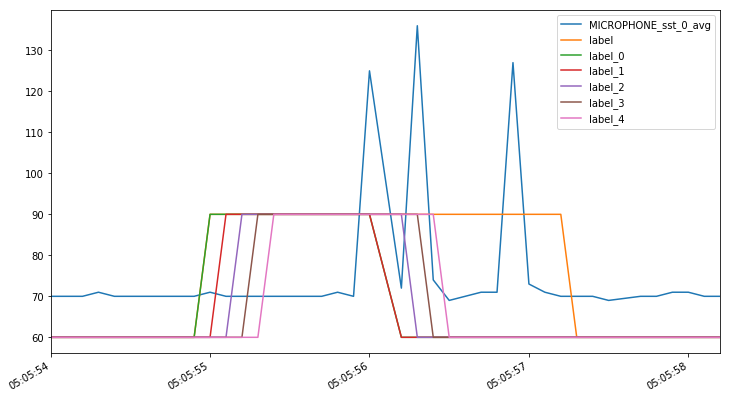

move_window(248, by=0.1, window_length=activity_length)


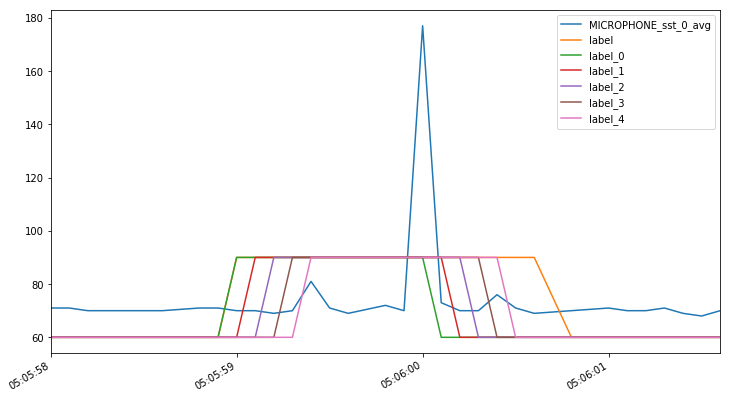

move_window(249, by=0.1, window_length=activity_length)


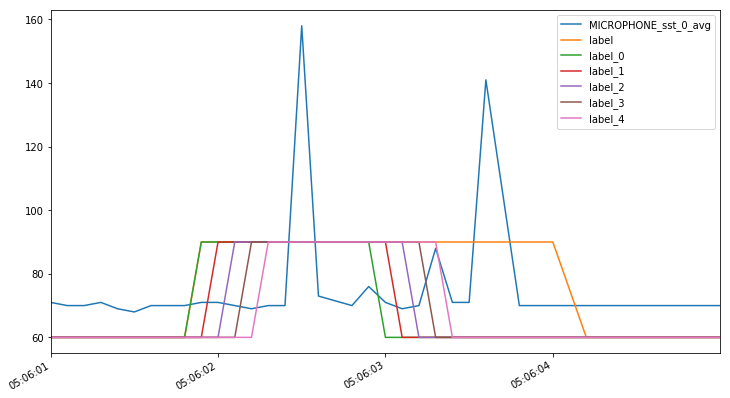

move_window(250, by=0.1, window_length=activity_length)


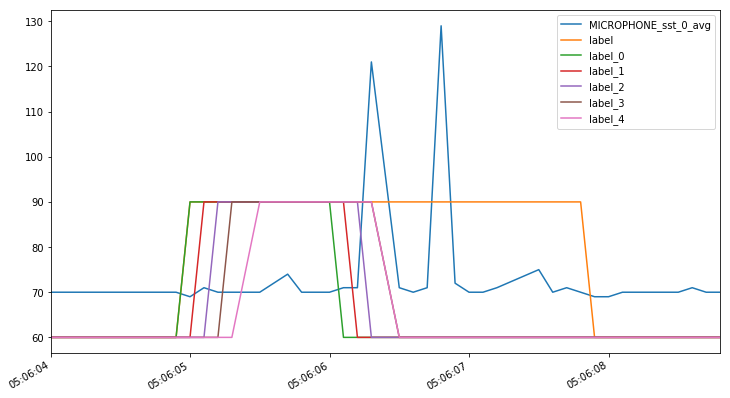

move_window(251, by=0.1, window_length=activity_length)


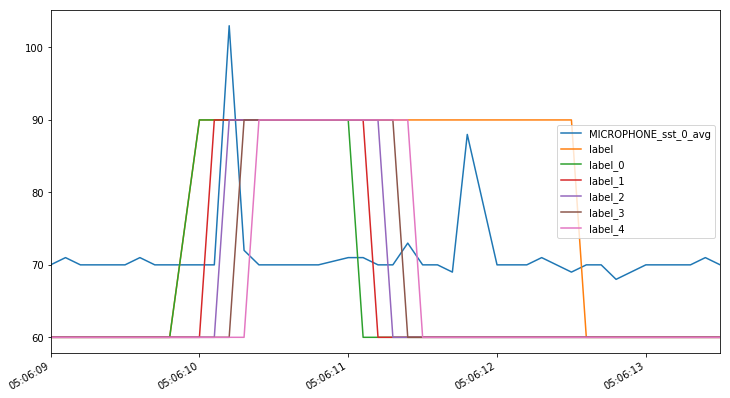

move_window(252, by=0.1, window_length=activity_length)


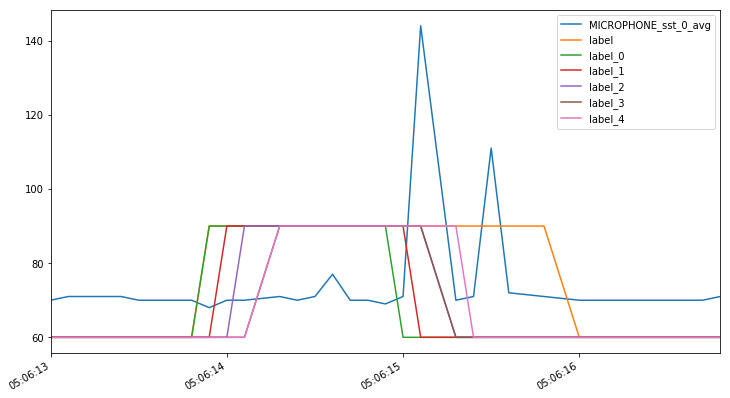

move_window(253, by=0.1, window_length=activity_length)


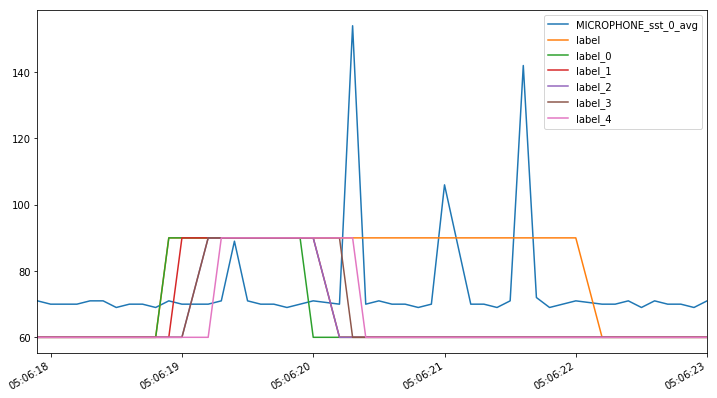

move_window(254, by=0.1, window_length=activity_length)


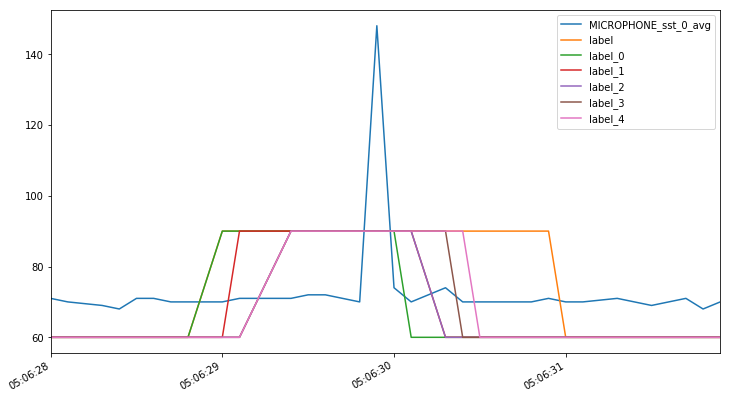

move_window(255, by=0.1, window_length=activity_length)


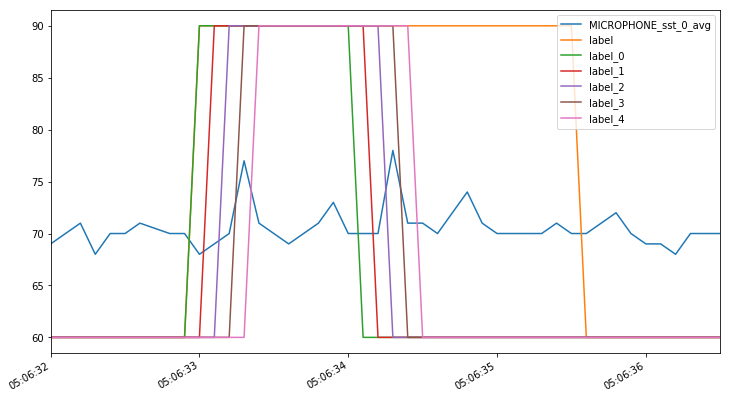

move_window(256, by=0.1, window_length=activity_length)


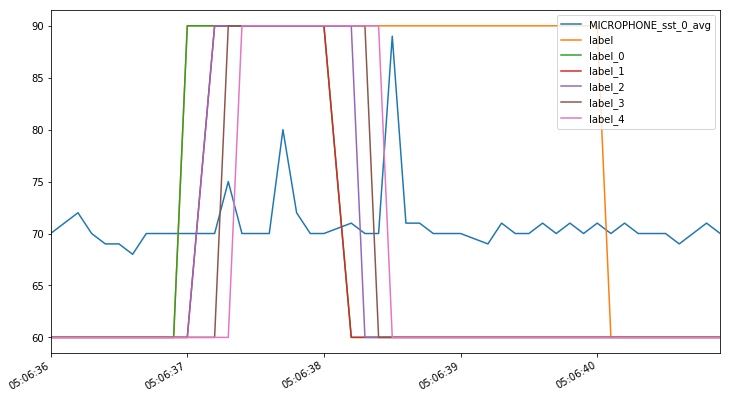

move_window(257, by=0.1, window_length=activity_length)


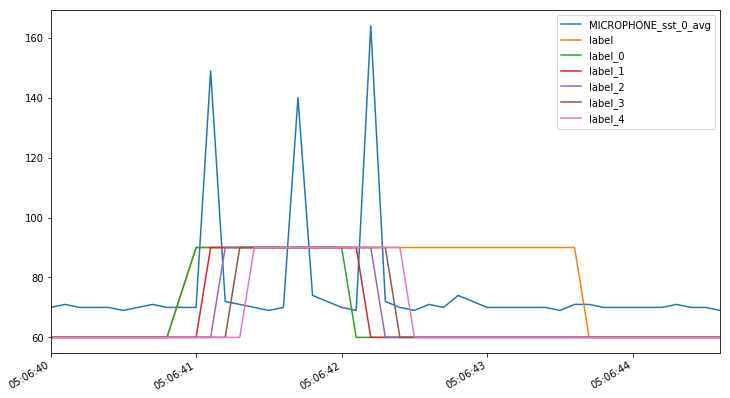

move_window(258, by=0.1, window_length=activity_length)


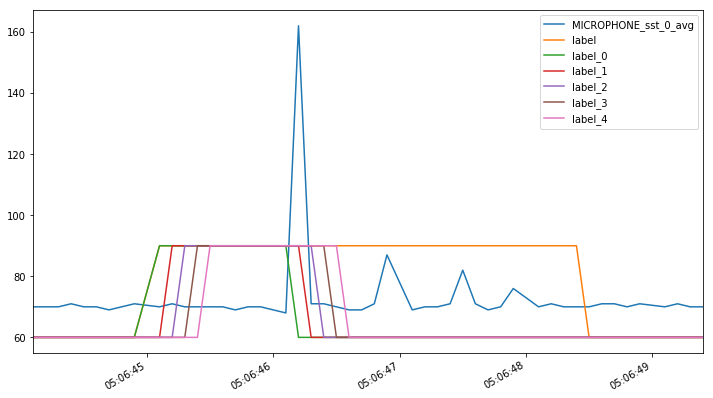

move_window(259, by=0.1, window_length=activity_length)


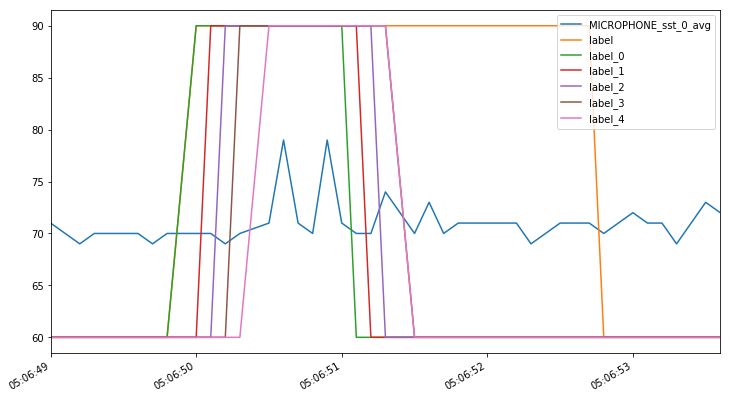

move_window(260, by=0.1, window_length=activity_length)


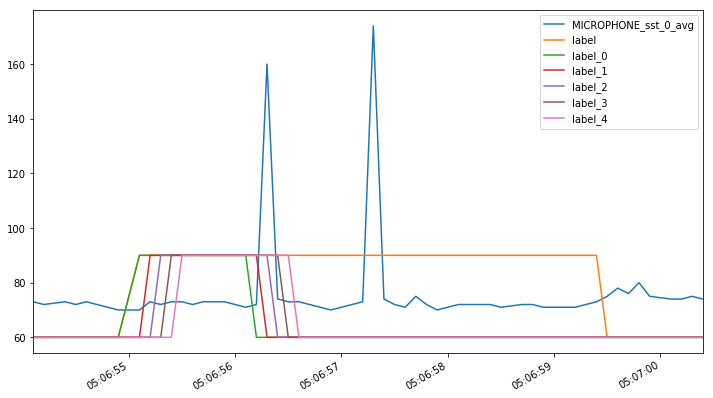

move_window(261, by=0.1, window_length=activity_length)


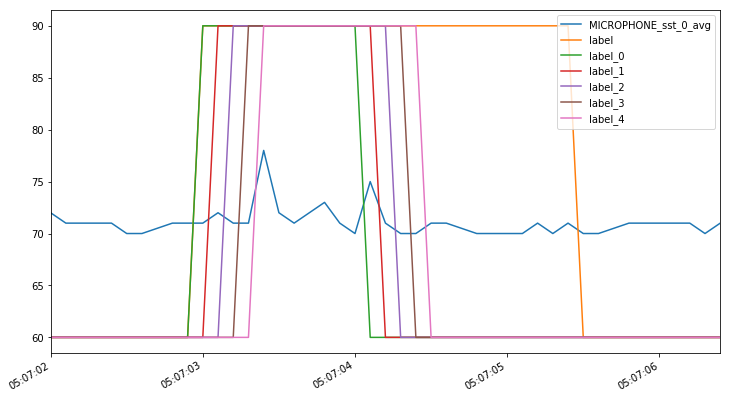

move_window(262, by=0.1, window_length=activity_length)


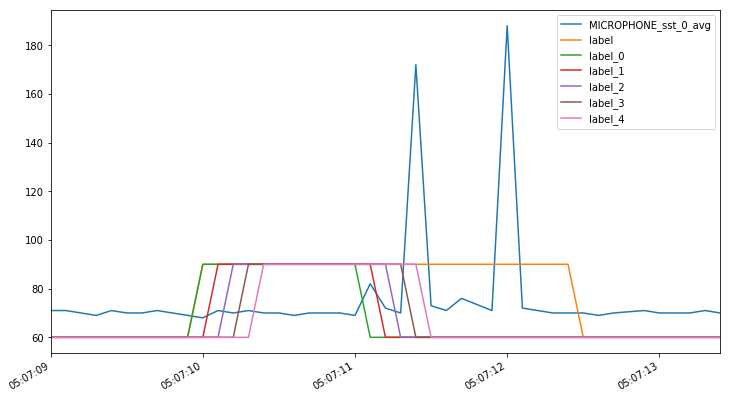

move_window(263, by=0.1, window_length=activity_length)


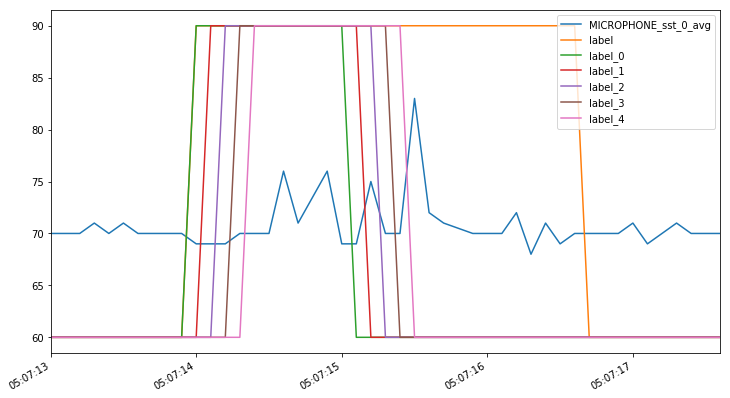

move_window(264, by=0.1, window_length=activity_length)


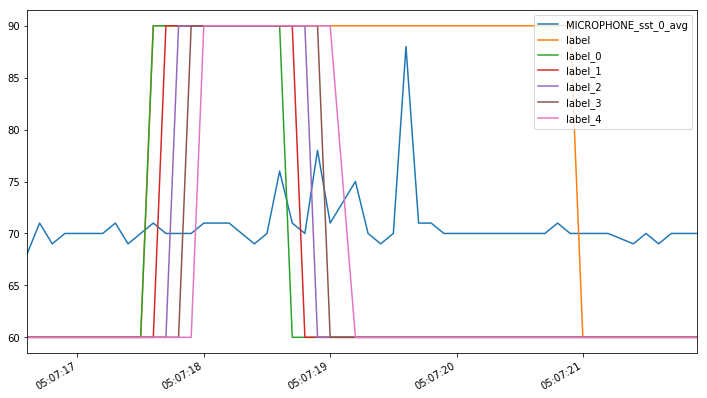

In [33]:
activity = 'Knocking'
activity_length = 1

activity_labels = labels.loc[labels.label == configuration['activities'].index(activity)].copy()
activity_labels['idx'] = activity_labels.index

for idx, since, until in activity_labels[['idx', 'since', 'until']].values:
    since_ = pd.Timestamp(since) - pd.Timedelta(seconds=1)
    until_ = pd.Timestamp(until) + pd.Timedelta(seconds=1)

    since = pd.Timestamp(since)
    until = pd.Timestamp(until)
#     print(idx, since, until)
    print('move_window(' + str(idx) + ', by=0.1, window_length=activity_length)')

    subdf = df.loc[df.index >= since_]
    subdf = subdf.loc[subdf.index <= until_]
    subdf = subdf[['MICROPHONE_sst_0_avg']]
    subdf['label'] = [90 if since <= pd.Timestamp(dt) and pd.Timestamp(dt) <= until else 60 for dt in subdf.index.values]

    for i in range(5):
        since_ = pd.Timestamp(since) + pd.Timedelta(seconds=i / 10)
        until_ = pd.Timestamp(since_) + pd.Timedelta(seconds=activity_length)
        subdf['label_' + str(i)] = [90 if since_ <= pd.Timestamp(dt) and pd.Timestamp(dt) <= until_ else 60 for dt in subdf.index.values]

    if len(subdf) == 0:
        print('No data')
        continue
        
    subdf.plot()
#     ticks = subdf.index.values
#     plt.xticks(np.arange(0.5, len(ticks), 10), ticks[::10], rotation='vertical')
    plt.show()

In [27]:
def move_window(activity_id, by, window_length):
    since = labels[labels.index == activity_id].since.values[0]
    since_ = since + pd.Timedelta(seconds=by)
    until_ = since_ + pd.Timedelta(seconds=window_length)
    print(since_, until_)
    labels.loc[labels.index == activity_id, 'since'] = since_
    labels.loc[labels.index == activity_id, 'until'] = until_

def remove_window(activity_id):
    labels.loc[labels.index == activity_id, 'label'] = -1



2017-07-08 04:49:50.600000 2017-07-08 04:49:51.600000
2017-07-08 04:50:00.300000 2017-07-08 04:50:01.300000
2017-07-08 04:50:10.100000 2017-07-08 04:50:11.100000
2017-07-08 04:50:31 2017-07-08 04:50:32
2017-07-08 04:50:42 2017-07-08 04:50:43
2017-07-08 04:50:50.900000 2017-07-08 04:50:51.900000
2017-07-08 04:51:04.200000 2017-07-08 04:51:05.200000
2017-07-08 04:51:10.500000 2017-07-08 04:51:11.500000
2017-07-08 04:51:17.200000 2017-07-08 04:51:18.200000
2017-07-08 04:51:31.400000 2017-07-08 04:51:32.400000
2017-07-08 04:51:39.300000 2017-07-08 04:51:40.300000
2017-07-08 04:51:57.500000 2017-07-08 04:51:58.500000
2017-07-08 05:02:46.600000 2017-07-08 05:02:47.600000
2017-07-08 05:02:55.500000 2017-07-08 05:02:56.500000
2017-07-08 05:03:04.400000 2017-07-08 05:03:05.400000
2017-07-08 05:03:12.300000 2017-07-08 05:03:13.300000
2017-07-08 05:03:26.300000 2017-07-08 05:03:27.300000
2017-07-08 05:03:37.100000 2017-07-08 05:03:38.100000
2017-07-08 05:03:44.700000 2017-07-08 05:03:45.700000
20

In [29]:
def activity_id_for(timestamp):
    sublabels = labels.loc[labels.since <= timestamp]
    sublabels = sublabels.loc[labels.until >= timestamp]
    if len(sublabels) == 0:
        return -1
    if sublabels.label.values[0] == -1:
        return -1
    return sublabels.index.values[0]

activities['id'] = [activity_id_for(pd.Timestamp(ts)) for ts in activities.index]

In [48]:
activities.loc[activities.id == 71]

,id
2017-06-17 04:20:05.100,71
2017-06-17 04:20:05.200,71
2017-06-17 04:20:05.300,71
2017-06-17 04:20:05.400,71
2017-06-17 04:20:05.500,71
2017-06-17 04:20:05.600,71
2017-06-17 04:20:05.700,71
2017-06-17 04:20:05.800,71
2017-06-17 04:20:05.900,71
2017-06-17 04:20:06.100,71


In [30]:
activities.to_csv(dataset_path + 'activities.csv')